In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In /home/akshay/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/akshay/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/akshay/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/akshay/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/akshay/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

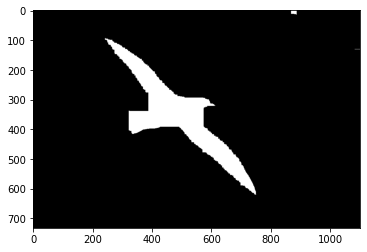

In [2]:
image = "../data/bird.jpg"
img = cv2.imread(image)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

edge = cv2.Canny(img,240,255)
dilated = cv2.dilate(edge,None,iterations = 20)
eroded = cv2.erode(dilated,None,iterations = 30)
plt.imshow(eroded,cmap="gray")

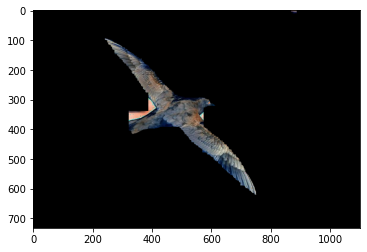

In [3]:
masked = img.copy()
for i in range(3):
    masked[:,:,i] = img[:,:,i]*eroded
plt.imshow(masked)

In [33]:
import cv2
import numpy as np
import sys,os
from tqdm import tqdm

# script_dir = sys.path[0] # This gives the directory in which our script is running on the system
# img_path = os.path.join(script_dir, '../data/'+sys.argv[1])


def im2double(im,d):
    #im1,im2,im3 = cv2.split(im)
#     out = im.copy()
#     for i in range(d):
#         out[:,:,i] = (out[:,:,i] - np.min(out[:,:,i]))/(np.max(out[:,:,i])-np.min(out[:,:,i]))
    
    im1 = im[:,:,0]
    im2 = im[:,:,1]
    im3 = im[:,:,2]
    out1 = (im1.astype(np.float64) - np.min(im1.ravel())) / (np.max(im1.ravel()) - np.min(im1.ravel()))
    out2 = (im2.astype(np.float64) - np.min(im2.ravel())) / (np.max(im2.ravel()) - np.min(im2.ravel()))
    out3 = (im3.astype(np.float64) - np.min(im3.ravel())) / (np.max(im3.ravel()) - np.min(im3.ravel()))
    out = cv2.merge((out1,out2,out3))
    return out

def meanShift(img):
    r,c,d = img.shape
    img = im2double(img,d)
    gaussian_blur = cv2.GaussianBlur(img, (5,5), 1.0)
    
    #hsv_image = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    #h,s,v = cv2.split(hsv_image)
    # row = shp[0]//4
    # col = shp[1]//4
    row,col = 128,128
    newimg = cv2.resize(img,(row,col))

    
    result1 = np.zeros((row,col))
    result2 = np.zeros((row,col))
    result3 = np.zeros((row,col))
    h=0.1
    sigma = 11.0 
    count = 0
    window_size = 7
    padded = np.concatenate((np.concatenate((np.zeros((row,window_size,3)), newimg),axis=1), np.zeros((row,window_size,3))),axis=1)

    padded = np.concatenate((np.concatenate((np.zeros((window_size,col+2*(window_size),3)),padded),axis=0), np.zeros((window_size, col+2*(window_size),3))),axis=0)
    #padded = np.zeros((row+2*window_size,col+2*window_size))
    r,c,d = padded.shape
    #r,c = padded.shape
    print(padded.shape)

    #isotropic
    #Spatial
    spatial = np.zeros((2*window_size+1,2*window_size+1))
    for is1 in range(2*window_size+1):
        for is2 in range(2*window_size+1):
            spatial[is1][is2] = ((is1-window_size)**2+(is2-window_size)**2)**0.5
    spatial = np.exp(-(spatial/sigma)**2)

    
    for idx1 in tqdm(range(window_size,r-window_size)):
        for idx2 in range(window_size,c-window_size):
            window = padded[idx1-window_size:idx1+window_size+1, idx2-window_size:idx2+window_size+1]
            #print(newimg[idx1][idx2])
            (x1,x2,x3) = newimg[idx1-window_size][idx2-window_size]
            N1 = 0.0 #numerator
            D1 = 1.0 #denominator
            N2 = 0.0 #numerator
            D2 = 1.0 #denominator
            N3 = 0.0 #numerator
            D3 = 1.0 #denominator


            for itern in range(30): # number of iterations
                for idx3 in range(2*window_size+1):
                    for idx4 in range(2*window_size+1):
                        (x_i1,x_i2,x_i3) = window[idx3][idx4]
                        diff1 = abs(x1-x_i1)
                        diff2 = abs(x2-x_i2)
                        diff3 = abs(x3-x_i3)

                        d1 = np.exp(-(diff1/h)**2)*spatial[idx3][idx4]
                        n1 = x_i1*d1
                        N1 += n1
                        D1 += d1

                        d2 = np.exp(-(diff2/h)**2)*spatial[idx3][idx4]
                        n2 = x_i2*d2
                        N2 += n2
                        D2 += d2

                        d3 = np.exp(-(diff3/h)**2)*spatial[idx3][idx4]
                        n3 = x_i3*d3
                        N3 += n3
                        D3 += d3

                x1 = float(N1)/D1 # in each iteration, x changes
                x2 = float(N2)/D2 # in each iteration, x changes
                x3 = float(N3)/D3 # in each iteration, x changes

            result1[idx1-window_size][idx2-window_size] = x1
            result2[idx1-window_size][idx2-window_size] = x2
            result3[idx1-window_size][idx2-window_size] = x3

#             if count%1000 == 0:
#                 print(count)
#             count += 1
    '''
    cv2.imshow('Original Image',spatial)
    print(spatial)
    '''
    result = cv2.merge((result1,result2,result3))
    #print(result)
    return result

In [34]:
# img = cv2.imread("../data/bird.jpg") # Read image here
# img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# meanShift(img)

  0%|          | 0/128 [00:00<?, ?it/s]

(142, 142, 3)


100%|██████████| 128/128 [33:59<00:00, 15.93s/it]


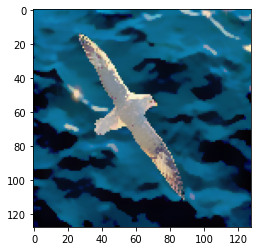

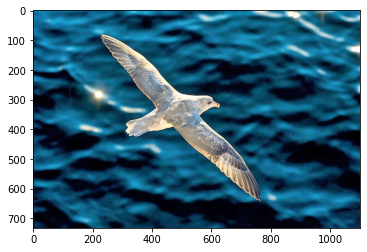

In [35]:
img = cv2.imread("../data/bird.jpg") # Read image here
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
result2 = meanShift(img)
plt.figure()
plt.imshow(result2)
plt.figure()
plt.imshow(img)

  0%|          | 0/128 [00:00<?, ?it/s]

(142, 142, 3)


100%|██████████| 128/128 [33:14<00:00, 15.58s/it]


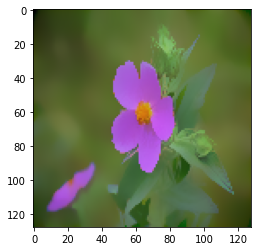

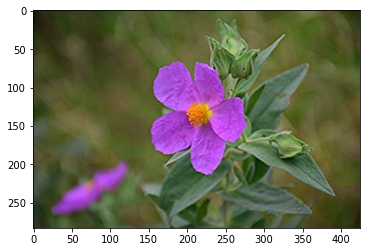

In [47]:
img = cv2.imread("../data/flower.jpg") # Read image here
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
result1 = meanShift(img)
plt.figure()
plt.imshow(result1)
plt.figure()
plt.imshow(img)

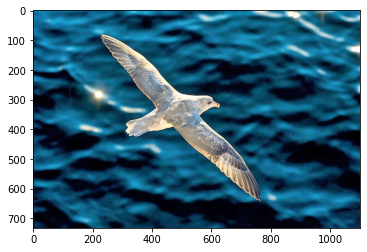

In [13]:
plt.figure()
plt.imshow(img)

(128, 128, 3)


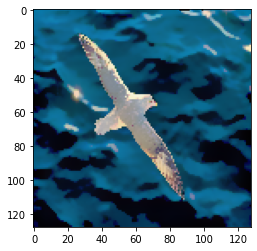

In [48]:
print(result2.shape)

r,c,d = result2.shape
result_copy = result2.copy()
for i in range(r):
    for j in range(int(c)):
        a,b,c = result_copy[i,j,:]
        if a+b+c>=(3*sort[0][0])*0.9:
            result_copy[i,j,:] = 0

plt.imshow(result_copy)

100%|██████████| 128/128 [00:00<00:00, 7089.28it/s]


[(0.665027, 6285), (0.30663, 10097)]
2


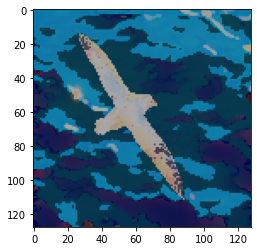

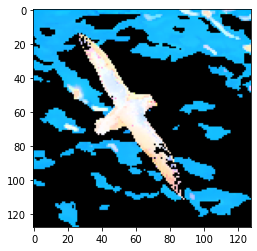

In [142]:
#print(np.unique(result[:,:,0]))
masked = np.zeros_like(result)
# for i in range(3):
#     for j in range(64):
#         for k in range(64):
#             if result[j,k,i]>0.7:
#                 masked[j,k,i] = 1
#             else:
#                 masked[j,k,i] = 0

unique_intensities ={}

result = (result2).astype(np.float32)
#print(result.shape)

hsv_result = cv2.cvtColor(result,cv2.COLOR_RGB2HSV)
h,s,v = cv2.split(hsv_result)

r,c = v.shape
diff = np.zeros_like(v)

for i in tqdm(range(r)):
    for j in range(c):
        inten = v[i,j]
        flag=0
        if inten not in unique_intensities:
            diff = 999999
            intensity = 0
            for k in unique_intensities:
                if abs(inten-k)<0.35:
                    flag=1
                    if diff>abs(inten-k):
                        diff = abs(inten-k)
                        intensity=k 
                    v[i,j] = intensity
            if flag==0:
                unique_intensities[inten] = 0
            else:
                unique_intensities[intensity] += 1
        else:
            unique_intensities[inten] += 1

sort =sorted(unique_intensities.items(), key = lambda kv:(kv[1], kv[0])) 
print(sort)
h_copy = np.ones_like(h)
s_copy = np.ones_like(s)
v_copy = v.copy()
for i in tqdm(range(r)):
    for j in range(c):
        if v_copy[i,j]==sort[-1][0]:
            v_copy[i,j] = 0
        else:
            v_copy[i,j] = 1


"""
for z in range(3):
    for i in range(64):
        for j in range(64):
            inten = result[i,j,z]
            flag=0
            if inten not in unique_intensities:
                for k in unique_intensities:
                    if abs(inten-k)<0.25:
                        masked[i,j,z] = k
                        flag=1
                        break
                if flag==0:
                    unique_intensities.append(inten) 

"""
masked = cv2.merge((h,s,v))
masked_2 = cv2.merge((h,s,v_copy))
masked = cv2.cvtColor(masked,cv2.COLOR_HSV2RGB)
masked_2 = cv2.cvtColor(masked_2,cv2.COLOR_HSV2RGB)
plt.figure()
plt.imshow(masked)
plt.figure()
plt.imshow(masked_2)
print(len(unique_intensities))
# for key,value in unique_intensities.items():
#     print(key," : ", value)
#print(np.unique(masked,axis=0))

(128, 128)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


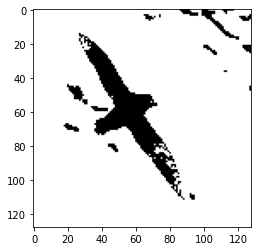

In [144]:
vectorized_mask = np.zeros((masked_2.shape[0],masked_2.shape[1]))
for i in range(masked_2.shape[0]):
    for j in range(masked_2.shape[1]):
            vectorized_mask[i,j] = masked_2[i,j,0] * masked_2[i,j,1] * masked_2[i,j,2]
            if vectorized_mask[i,j]>0.4:   #0.02 works for flower , 0.4 for bird
                vectorized_mask[i,j]=0
            else:
                vectorized_mask[i,j]=1
print(vectorized_mask.shape)

plt.imshow(vectorized_mask,cmap='gray')
print(vectorized_mask)

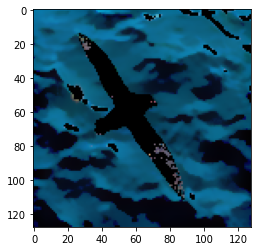

In [145]:
masked_img = np.zeros((result2.shape[0],result2.shape[1],3))
masked_img[:,:,0] = result2[:,:,0]*vectorized_mask
masked_img[:,:,1] = result2[:,:,1]*vectorized_mask
masked_img[:,:,2] = result2[:,:,2]*vectorized_mask
plt.imshow(masked_img)

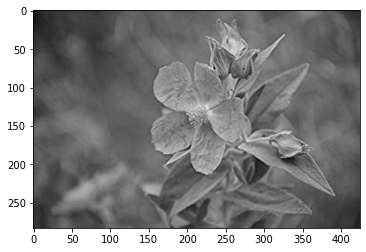

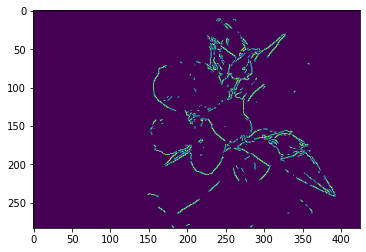

In [146]:
gray_input = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.figure()
plt.imshow(gray_input,cmap="gray")
canny_gray = cv2.Canny(gray_input,220,240)
plt.figure()
plt.imshow(canny_gray)

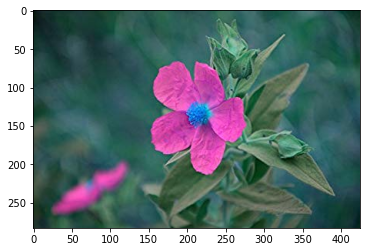

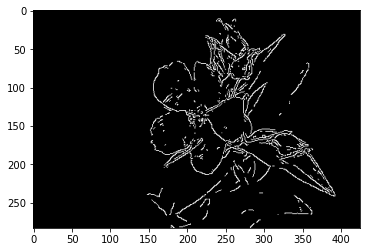

In [159]:
flower_img = cv2.imread("../data/flower.jpg")
plt.figure()
plt.imshow(flower_img)
flower_img_gray = cv2.cvtColor(flower_img,cv2.COLOR_BGR2GRAY)
flower_canny_gray = cv2.Canny(flower_img_gray,150,180)
plt.figure()
plt.imshow(flower_canny_gray,cmap="gray")